In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Load and preprocess the data
data = pd.read_excel("/kaggle/input/generated-data/generated_data.xlsx")
X = data.drop(columns=['Class']).values
y = data['Class'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

encoder = OneHotEncoder(sparse=False)
y_one_hot = encoder.fit_transform(y.reshape(-1, 1))

# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_one_hot, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert data to tensors
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)
X_val_tensor = torch.Tensor(X_val)
y_val_tensor = torch.Tensor(y_val)
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)

# Create DataLoader objects
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, hidden_layers):
        super(MLP, self).__init__()
        
        layers = []
        layers.append(nn.Linear(X_train.shape[1], 64))
        layers.append(nn.ReLU())
        
        in_units = 64
        for units in hidden_layers:
            layers.append(nn.Linear(in_units, units))
            layers.append(nn.ReLU())
            in_units = units
        
        layers.append(nn.Linear(in_units, y_train.shape[1]))
        layers.append(nn.Softmax(dim=1))
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Train and evaluate the model
def train_and_evaluate_model(hidden_layers, train_loader, val_loader, test_loader):
    model = MLP(hidden_layers)
    optimizer = optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()

    # Training loop without monitoring
    for epoch in range(20):
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.argmax(dim=1))
            loss.backward()
            optimizer.step()

    # Evaluation on the test set
    model.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            test_total += targets.size(0)
            test_correct += (predicted == targets.argmax(dim=1)).sum().item()

    test_accuracy = test_correct / test_total
    return test_accuracy

# Evaluate the model with different configurations of hidden layers
test_accuracy_1_hidden = train_and_evaluate_model([128], train_loader, val_loader, test_loader)
print(f"Test Accuracy with 1 hidden layer: {test_accuracy_1_hidden:.4f}")

test_accuracy_2_hidden = train_and_evaluate_model([128, 64], train_loader, val_loader, test_loader)
print(f"Test Accuracy with 2 hidden layers: {test_accuracy_2_hidden:.4f}")

test_accuracy_3_hidden = train_and_evaluate_model([128, 64, 32], train_loader, val_loader, test_loader)
print(f"Test Accuracy with 3 hidden layers: {test_accuracy_3_hidden:.4f}")


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Test Accuracy with 1 hidden layer: 0.6871
Test Accuracy with 2 hidden layers: 0.5319
Test Accuracy with 3 hidden layers: 0.2894


In [37]:
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Load and preprocess data
data = pd.read_excel("/kaggle/input/generated-data/generated_data.xlsx")
X = data.drop(columns=['Class']).values
y = data['Class'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

encoder = OneHotEncoder(sparse=False)
y_one_hot = encoder.fit_transform(y.reshape(-1, 1))

X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_one_hot, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)
X_val_tensor = torch.Tensor(X_val)
y_val_tensor = torch.Tensor(y_val)
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Define model
class MLP(nn.Module):
    def __init__(self, hidden_layers):
        super(MLP, self).__init__()
        layers = [nn.Linear(X_train.shape[1], 64), nn.ReLU()]
        in_units = 64
        for units in hidden_layers:
            layers.append(nn.Linear(in_units, units))
            layers.append(nn.ReLU())
            in_units = units
        layers.append(nn.Linear(in_units, y_train.shape[1]))
        layers.append(nn.Softmax(dim=1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Train and evaluate model
def train_and_evaluate_model(hidden_layers, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    model = MLP(hidden_layers)
    optimizer = optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()

    for epoch in range(20):
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.argmax(dim=1))
            loss.backward()
            optimizer.step()

    test_correct, test_total = 0, 0
    with torch.no_grad():
        model.eval()
        for inputs, targets in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            test_total += targets.size(0)
            test_correct += (predicted == targets.argmax(dim=1)).sum().item()

    return test_correct / test_total

# Experiment with different batch sizes
batch_sizes = [16, 32, 64, 128]
results = []

for batch_size in batch_sizes:
    accuracy_1_hidden = train_and_evaluate_model([128], batch_size)
    accuracy_2_hidden = train_and_evaluate_model([128, 64], batch_size)
    accuracy_3_hidden = train_and_evaluate_model([128, 64, 32], batch_size)
    results.append((batch_size, accuracy_1_hidden, accuracy_2_hidden, accuracy_3_hidden))

# Print results
for batch_size, acc1, acc2, acc3 in results:
    print(f"Batch Size: {batch_size}, 1 Hidden Layer: {acc1:.4f}, 2 Hidden Layers: {acc2:.4f}, 3 Hidden Layers: {acc3:.4f}")


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Batch Size: 16, 1 Hidden Layer: 0.7306, 2 Hidden Layers: 0.5135, 3 Hidden Layers: 0.1916
Batch Size: 32, 1 Hidden Layer: 0.7758, 2 Hidden Layers: 0.4715, 3 Hidden Layers: 0.2955
Batch Size: 64, 1 Hidden Layer: 0.7713, 2 Hidden Layers: 0.4122, 3 Hidden Layers: 0.4206
Batch Size: 128, 1 Hidden Layer: 0.8364, 2 Hidden Layers: 0.4425, 3 Hidden Layers: 0.3757


In [27]:
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

data = pd.read_excel("/kaggle/input/generated-data/generated_data.xlsx")
X = data.drop(columns=['Class']).values
y = data['Class'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

encoder = OneHotEncoder(sparse=False)
y_one_hot = encoder.fit_transform(y.reshape(-1, 1))

X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_one_hot, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)
X_val_tensor = torch.Tensor(X_val)
y_val_tensor = torch.Tensor(y_val)
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class MLP(nn.Module):
    def __init__(self, hidden_layers):
        super(MLP, self).__init__()
        
        layers = []
        layers.append(nn.Linear(X_train.shape[1], 64))
        layers.append(nn.ELU())
        
        in_units = 64
        for units in hidden_layers:
            layers.append(nn.Linear(in_units, units))
            layers.append(nn.ELU())
            in_units = units
        
        layers.append(nn.Linear(in_units, y_train.shape[1]))
        layers.append(nn.Softmax(dim=1))
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

def train_and_evaluate_model_with_neurons(hidden_layers, train_loader, val_loader, test_loader):
    model = MLP(hidden_layers)
    optimizer = optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()

    for epoch in range(20):
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.argmax(dim=1))
            loss.backward()
            optimizer.step()

    model.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            test_total += targets.size(0)
            test_correct += (predicted == targets.argmax(dim=1)).sum().item()

    test_accuracy = test_correct / test_total
    return test_accuracy

neurons_configurations = [
    [128],
    [256, 128],
    [512, 256, 128],
    [1024, 512, 256, 128]
]

for neurons in neurons_configurations:
    print(f"\nTesting with neurons configuration: {neurons}")
    
    test_accuracy = train_and_evaluate_model_with_neurons(neurons, train_loader, val_loader, test_loader)
    print(f"Test Accuracy with neurons configuration {neurons}: {test_accuracy:.4f}")


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(



Testing with neurons configuration: [128]
Test Accuracy with neurons configuration [128]: 0.6951

Testing with neurons configuration: [256, 128]
Test Accuracy with neurons configuration [256, 128]: 0.3835

Testing with neurons configuration: [512, 256, 128]
Test Accuracy with neurons configuration [512, 256, 128]: 0.0188

Testing with neurons configuration: [1024, 512, 256, 128]
Test Accuracy with neurons configuration [1024, 512, 256, 128]: 0.0199


In [29]:
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

data = pd.read_excel("/kaggle/input/generated-data/generated_data.xlsx")
X = data.drop(columns=['Class']).values
y = data['Class'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

encoder = OneHotEncoder(sparse=False)
y_one_hot = encoder.fit_transform(y.reshape(-1, 1))

X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_one_hot, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)
X_val_tensor = torch.Tensor(X_val)
y_val_tensor = torch.Tensor(y_val)
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class MLP(nn.Module):
    def __init__(self, hidden_layers, weight_init):
        super(MLP, self).__init__()
        
        layers = []
        layers.append(nn.Linear(X_train.shape[1], 64))
        layers.append(nn.ELU())
        
        in_units = 64
        for units in hidden_layers:
            layers.append(nn.Linear(in_units, units))
            layers.append(nn.ELU())
            in_units = units
        
        layers.append(nn.Linear(in_units, y_train.shape[1]))
        layers.append(nn.Softmax(dim=1))
        
        self.model = nn.Sequential(*layers)

        # Apply weight initialization method
        if weight_init == 'glorot_uniform':
            self.apply(self.glorot_uniform_init)
        elif weight_init == 'he_normal':
            self.apply(self.he_normal_init)
        elif weight_init == 'lecun_normal':
            self.apply(self.lecun_normal_init)
        elif weight_init == 'random_normal':
            self.apply(self.random_normal_init)
        elif weight_init == 'random_uniform':
            self.apply(self.random_uniform_init)
    
    def forward(self, x):
        return self.model(x)
    
    def glorot_uniform_init(self, layer):
     if isinstance(layer, nn.Linear):
        nn.init.xavier_uniform_(layer.weight)  # Use xavier_uniform_ instead of glorot_uniform_
        if layer.bias is not None:
            nn.init.zeros_(layer.bias)

    
    def he_normal_init(self, layer):
        if isinstance(layer, nn.Linear):
            nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
            if layer.bias is not None:
                nn.init.zeros_(layer.bias)
    
    def lecun_normal_init(self, layer):
        if isinstance(layer, nn.Linear):
            nn.init.kaiming_normal_(layer.weight, nonlinearity='leaky_relu')
            if layer.bias is not None:
                nn.init.zeros_(layer.bias)
    
    def random_normal_init(self, layer):
        if isinstance(layer, nn.Linear):
            nn.init.normal_(layer.weight, mean=0, std=0.01)
            if layer.bias is not None:
                nn.init.zeros_(layer.bias)
    
    def random_uniform_init(self, layer):
        if isinstance(layer, nn.Linear):
            nn.init.uniform_(layer.weight, a=-0.1, b=0.1)
            if layer.bias is not None:
                nn.init.zeros_(layer.bias)

def train_and_evaluate_model_with_init(hidden_layers, train_loader, val_loader, test_loader, weight_init):
    model = MLP(hidden_layers, weight_init)
    optimizer = optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()

    for epoch in range(20):
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.argmax(dim=1))
            loss.backward()
            optimizer.step()

    model.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            test_total += targets.size(0)
            test_correct += (predicted == targets.argmax(dim=1)).sum().item()

    test_accuracy = test_correct / test_total
    return test_accuracy

initializers = [
    'glorot_uniform',  # Xavier Initialization
    'he_normal',       # He Initialization
    'lecun_normal',    # LeCun Initialization
    'random_normal',   # Random Normal Distribution
    'random_uniform'   # Random Uniform Distribution
]

hidden_layers = [128, 64]

for init_method in initializers:
    print(f"\nTesting with weight initialization method: {init_method}")
    
    test_accuracy = train_and_evaluate_model_with_init(hidden_layers, train_loader, val_loader, test_loader, init_method)
    print(f"Test Accuracy with {init_method} initialization: {test_accuracy:.4f}")


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(



Testing with weight initialization method: glorot_uniform
Test Accuracy with glorot_uniform initialization: 0.4830

Testing with weight initialization method: he_normal
Test Accuracy with he_normal initialization: 0.4825

Testing with weight initialization method: lecun_normal
Test Accuracy with lecun_normal initialization: 0.4065

Testing with weight initialization method: random_normal
Test Accuracy with random_normal initialization: 0.3931

Testing with weight initialization method: random_uniform
Test Accuracy with random_uniform initialization: 0.5131


In [30]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

data = pd.read_excel("/kaggle/input/generated-data/generated_data.xlsx")
X = data.drop(columns=['Class']).values
y = data['Class'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

encoder = OneHotEncoder(sparse=False)
y_one_hot = encoder.fit_transform(y.reshape(-1, 1))

X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_one_hot, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)
X_val_tensor = torch.Tensor(X_val)
y_val_tensor = torch.Tensor(y_val)
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class MLP(nn.Module):
    def __init__(self, hidden_layers, activation_fn):
        super(MLP, self).__init__()
        
        layers = []
        layers.append(nn.Linear(X_train.shape[1], 64))
        layers.append(activation_fn())
        
        in_units = 64
        for units in hidden_layers:
            layers.append(nn.Linear(in_units, units))
            layers.append(activation_fn())
            in_units = units
        
        layers.append(nn.Linear(in_units, y_train.shape[1]))
        layers.append(nn.Softmax(dim=1))
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

def train_and_evaluate_model_with_activation(hidden_layers, train_loader, val_loader, test_loader, activation_fn):
    model = MLP(hidden_layers, activation_fn)
    optimizer = optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()

    for epoch in range(20):
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.argmax(dim=1))
            loss.backward()
            optimizer.step()

    model.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            test_total += targets.size(0)
            test_correct += (predicted == targets.argmax(dim=1)).sum().item()

    test_accuracy = test_correct / test_total
    return test_accuracy

activation_functions = [nn.ReLU, nn.Tanh, nn.LeakyReLU]

hidden_layers = [128, 64]

for activation_fn in activation_functions:
    print(f"\nTesting with activation function: {activation_fn.__name__}")
    
    test_accuracy = train_and_evaluate_model_with_activation(hidden_layers, train_loader, val_loader, test_loader, activation_fn)
    print(f"Test Accuracy with {activation_fn.__name__}: {test_accuracy:.4f}")


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(



Testing with activation function: ReLU
Test Accuracy with ReLU: 0.6011

Testing with activation function: Tanh
Test Accuracy with Tanh: 0.9999

Testing with activation function: LeakyReLU
Test Accuracy with LeakyReLU: 0.3966


In [31]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

data = pd.read_excel("/kaggle/input/generated-data/generated_data.xlsx")
X = data.drop(columns=['Class']).values
y = data['Class'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

encoder = OneHotEncoder(sparse=False)
y_one_hot = encoder.fit_transform(y.reshape(-1, 1))

X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_one_hot, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)
X_val_tensor = torch.Tensor(X_val)
y_val_tensor = torch.Tensor(y_val)
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(X_train.shape[1], 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, y_train.shape[1]),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.model(x)

def train_and_evaluate_with_optimizer(optimizer_fn, momentum=None):
    model = MLP()
    if momentum is not None:
        optimizer = optimizer_fn(model.parameters(), lr=0.01, momentum=momentum)
    else:
        optimizer = optimizer_fn(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(20):
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.argmax(dim=1))
            loss.backward()
            optimizer.step()

    model.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            test_total += targets.size(0)
            test_correct += (predicted == targets.argmax(dim=1)).sum().item()

    return test_correct / test_total

optimizers = [
    (torch.optim.SGD, "SGD", None),
    (torch.optim.SGD, "SGD with Momentum", 0.9),
    (torch.optim.Adam, "Adam", None),
    (torch.optim.RMSprop, "RMSprop", None),
    (torch.optim.RMSprop, "RMSprop with Momentum", 0.9),
    (torch.optim.Adagrad, "AdaGrad", None)
]

for optimizer_fn, name, momentum in optimizers:
    accuracy = train_and_evaluate_with_optimizer(optimizer_fn, momentum)
    print(f"Test Accuracy using {name}: {accuracy:.4f}")


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Test Accuracy using SGD: 0.0310
Test Accuracy using SGD with Momentum: 0.2569
Test Accuracy using Adam: 0.0093
Test Accuracy using RMSprop: 0.0093
Test Accuracy using RMSprop with Momentum: 0.0099
Test Accuracy using AdaGrad: 0.3686


In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

data = pd.read_excel("/kaggle/input/generated-data/generated_data.xlsx")
X = data.drop(columns=['Class']).values
y = data['Class'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

encoder = OneHotEncoder(sparse=False)
y_one_hot = encoder.fit_transform(y.reshape(-1, 1))

X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_one_hot, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)
X_val_tensor = torch.Tensor(X_val)
y_val_tensor = torch.Tensor(y_val)
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class MLP(nn.Module):
    def __init__(self, hidden_layers):
        super(MLP, self).__init__()
        layers = []
        layers.append(nn.Linear(X_train.shape[1], 64))
        layers.append(nn.ReLU())
        in_units = 64
        for units in hidden_layers:
            layers.append(nn.Linear(in_units, units))
            layers.append(nn.ReLU())
            in_units = units
        layers.append(nn.Linear(in_units, y_train.shape[1]))
        layers.append(nn.Softmax(dim=1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


def train_and_evaluate_model(weight_decay, train_loader, test_loader):
    model = MLP([128, 64])
    optimizer = optim.Adam(model.parameters(), weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(20):
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.argmax(dim=1))
            loss.backward()
            optimizer.step()

    model.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            test_total += targets.size(0)
            test_correct += (predicted == targets.argmax(dim=1)).sum().item()

    test_accuracy = test_correct / test_total
    return test_accuracy

weight_decays = [0.0, 0.0001, 0.001, 0.01, 0.1]
results = {wd: train_and_evaluate_model(wd, train_loader, test_loader) for wd in weight_decays}
best_weight_decay = max(results, key=results.get)

print(f"Results for different weight decays: {results}")
print(f"Best weight decay: {best_weight_decay} with accuracy: {results[best_weight_decay]:.4f}")


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Results for different weight decays: {0.0: 0.39953333333333335, 0.0001: 0.40426666666666666, 0.001: 0.009066666666666667, 0.01: 0.009266666666666666, 0.1: 0.010066666666666666}
Best weight decay: 0.0001 with accuracy: 0.4043


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Test Accuracy without Batch Normalization: 0.6329
Test Accuracy with Batch Normalization: 0.9912


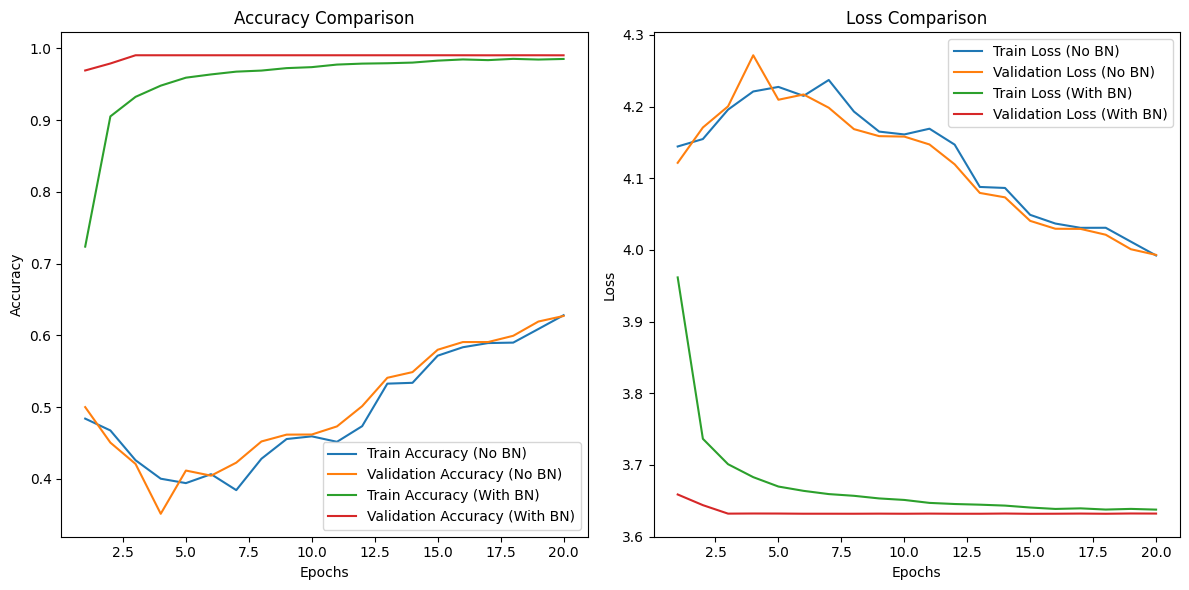

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

data = pd.read_excel("/kaggle/input/generated-data/generated_data.xlsx")
X = data.drop(columns=['Class']).values
y = data['Class'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

encoder = OneHotEncoder(sparse=False)
y_one_hot = encoder.fit_transform(y.reshape(-1, 1))

X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_one_hot, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)
X_val_tensor = torch.Tensor(X_val)
y_val_tensor = torch.Tensor(y_val)
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class MLP(nn.Module):
    def __init__(self, hidden_layers, use_batch_norm):
        super(MLP, self).__init__()
        layers = []
        layers.append(nn.Linear(X_train.shape[1], 64))
        if use_batch_norm:
            layers.append(nn.BatchNorm1d(64))
        layers.append(nn.ReLU())
        in_units = 64
        for units in hidden_layers:
            layers.append(nn.Linear(in_units, units))
            if use_batch_norm:
                layers.append(nn.BatchNorm1d(units))
            layers.append(nn.ReLU())
            in_units = units
        layers.append(nn.Linear(in_units, y_train.shape[1]))
        layers.append(nn.Softmax(dim=1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


def train_and_evaluate(use_batch_norm):
    model = MLP([128, 64], use_batch_norm)
    optimizer = optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()

    train_accuracies, val_accuracies, train_losses, val_losses = [], [], [], []

    for epoch in range(20):
        model.train()
        train_correct, train_total, train_loss = 0, 0, 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.argmax(dim=1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_total += targets.size(0)
            train_correct += (predicted == targets.argmax(dim=1)).sum().item()
        train_accuracies.append(train_correct / train_total)
        train_losses.append(train_loss / len(train_loader))

        model.eval()
        val_correct, val_total, val_loss = 0, 0, 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets.argmax(dim=1))
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += targets.size(0)
                val_correct += (predicted == targets.argmax(dim=1)).sum().item()
        val_accuracies.append(val_correct / val_total)
        val_losses.append(val_loss / len(val_loader))

    test_correct, test_total = 0, 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            test_total += targets.size(0)
            test_correct += (predicted == targets.argmax(dim=1)).sum().item()

    test_accuracy = test_correct / test_total
    return train_accuracies, val_accuracies, train_losses, val_losses, test_accuracy


train_acc_no_bn, val_acc_no_bn, train_loss_no_bn, val_loss_no_bn, test_acc_no_bn = train_and_evaluate(False)
train_acc_bn, val_acc_bn, train_loss_bn, val_loss_bn, test_acc_bn = train_and_evaluate(True)

print(f"Test Accuracy without Batch Normalization: {test_acc_no_bn:.4f}")
print(f"Test Accuracy with Batch Normalization: {test_acc_bn:.4f}")

epochs = range(1, 21)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc_no_bn, label="Train Accuracy (No BN)")
plt.plot(epochs, val_acc_no_bn, label="Validation Accuracy (No BN)")
plt.plot(epochs, train_acc_bn, label="Train Accuracy (With BN)")
plt.plot(epochs, val_acc_bn, label="Validation Accuracy (With BN)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Comparison")

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss_no_bn, label="Train Loss (No BN)")
plt.plot(epochs, val_loss_no_bn, label="Validation Loss (No BN)")
plt.plot(epochs, train_loss_bn, label="Train Loss (With BN)")
plt.plot(epochs, val_loss_bn, label="Validation Loss (With BN)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Comparison")

plt.tight_layout()
plt.show()


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Dropout Rate: 0.1, Test Accuracy: 0.5484
Dropout Rate: 0.2, Test Accuracy: 0.4909
Dropout Rate: 0.3, Test Accuracy: 0.5173
Dropout Rate: 0.4, Test Accuracy: 0.4958
Dropout Rate: 0.5, Test Accuracy: 0.4389


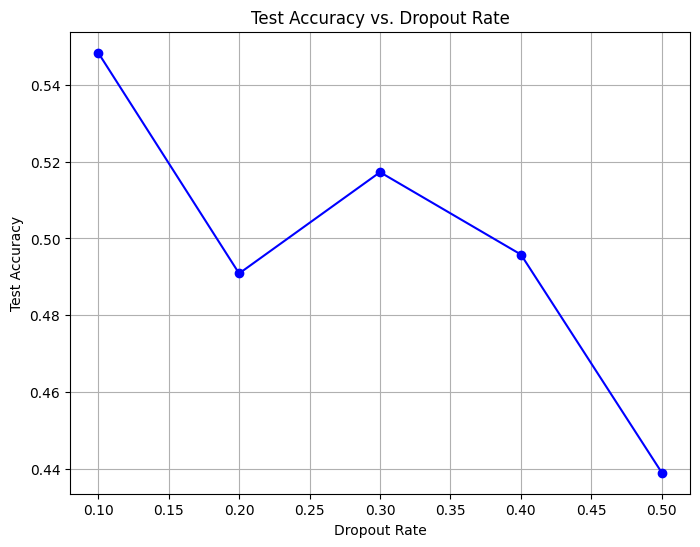

In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

data = pd.read_excel("/kaggle/input/generated-data/generated_data.xlsx")
X = data.drop(columns=['Class']).values
y = data['Class'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

encoder = OneHotEncoder(sparse=False)
y_one_hot = encoder.fit_transform(y.reshape(-1, 1))

X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_one_hot, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)
X_val_tensor = torch.Tensor(X_val)
y_val_tensor = torch.Tensor(y_val)
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class MLPWithDropout(nn.Module):
    def __init__(self, hidden_layers, dropout_rate):
        super(MLPWithDropout, self).__init__()
        layers = []
        layers.append(nn.Linear(X_train.shape[1], 64))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate))
        in_units = 64
        for units in hidden_layers:
            layers.append(nn.Linear(in_units, units))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            in_units = units
        layers.append(nn.Linear(in_units, y_train.shape[1]))
        layers.append(nn.Softmax(dim=1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


def train_and_evaluate_with_dropout(dropout_rate):
    model = MLPWithDropout([128, 64], dropout_rate)
    optimizer = optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()

    for epoch in range(20):
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.argmax(dim=1))
            loss.backward()
            optimizer.step()

    test_correct, test_total = 0, 0
    with torch.no_grad():
        model.eval()
        for inputs, targets in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            test_total += targets.size(0)
            test_correct += (predicted == targets.argmax(dim=1)).sum().item()

    test_accuracy = test_correct / test_total
    return test_accuracy


dropout_rates = [0.1, 0.2, 0.3, 0.4, 0.5]
accuracies = []

for rate in dropout_rates:
    acc = train_and_evaluate_with_dropout(rate)
    accuracies.append(acc)
    print(f"Dropout Rate: {rate}, Test Accuracy: {acc:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(dropout_rates, accuracies, marker='o', linestyle='-', color='b')
plt.xlabel("Dropout Rate")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy vs. Dropout Rate")
plt.grid()
plt.show()


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Hidden Layers: [64], Accuracy: 0.8823, Time: 60.91s, Parameters: 8484
Hidden Layers: [128, 64], Accuracy: 0.6617, Time: 72.67s, Parameters: 18724
Hidden Layers: [128, 64, 32], Accuracy: 0.4607, Time: 81.86s, Parameters: 17604
Hidden Layers: [256, 128, 64], Accuracy: 0.4112, Time: 103.68s, Parameters: 55588


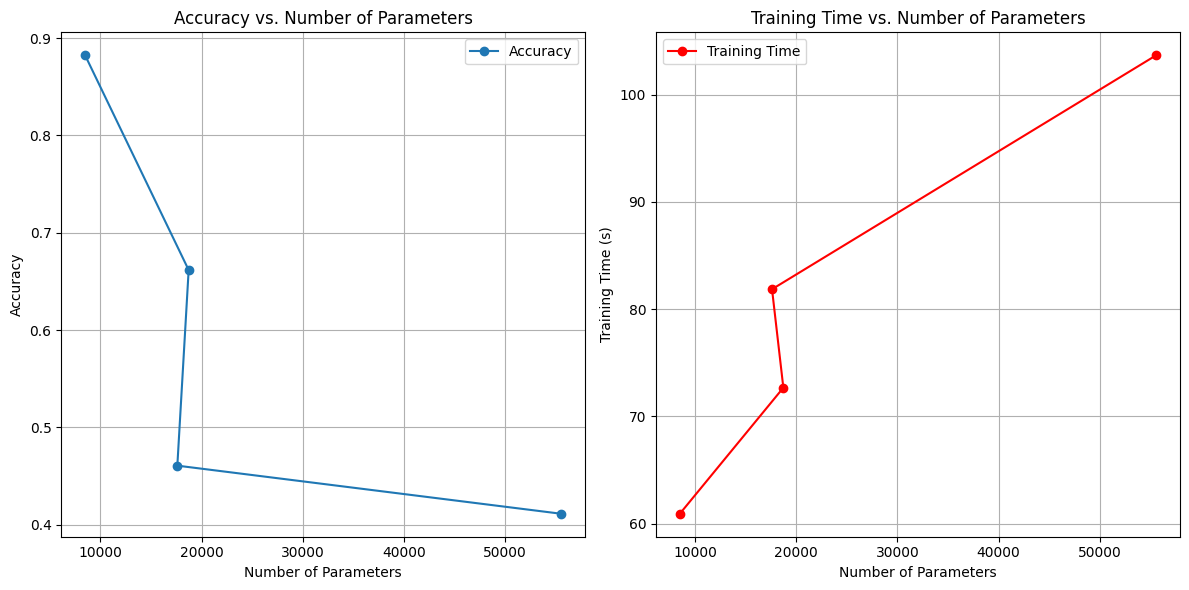

In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import time
import matplotlib.pyplot as plt

data = pd.read_excel("/kaggle/input/generated-data/generated_data.xlsx")
X = data.drop(columns=['Class']).values
y = data['Class'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

encoder = OneHotEncoder(sparse=False)
y_one_hot = encoder.fit_transform(y.reshape(-1, 1))

X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_one_hot, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


class MLP(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size):
        super(MLP, self).__init__()
        layers = []
        in_units = input_size
        for units in hidden_layers:
            layers.append(nn.Linear(in_units, units))
            layers.append(nn.ReLU())
            in_units = units
        layers.append(nn.Linear(in_units, output_size))
        layers.append(nn.Softmax(dim=1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


def train_and_evaluate_model(hidden_layers):
    input_size = X_train.shape[1]
    output_size = y_train.shape[1]
    model = MLP(input_size, hidden_layers, output_size)
    optimizer = optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()

    start_time = time.time()
    for epoch in range(20):
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.argmax(dim=1))
            loss.backward()
            optimizer.step()

    end_time = time.time()

    test_correct, test_total = 0, 0
    with torch.no_grad():
        model.eval()
        for inputs, targets in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            test_total += targets.size(0)
            test_correct += (predicted == targets.argmax(dim=1)).sum().item()

    test_accuracy = test_correct / test_total
    training_time = end_time - start_time
    total_params = sum(p.numel() for p in model.parameters())
    return test_accuracy, training_time, total_params


hidden_layers_list = [[64], [128, 64], [128, 64, 32], [256, 128, 64]]
accuracies = []
training_times = []
total_parameters = []

for hidden_layers in hidden_layers_list:
    acc, t_time, params = train_and_evaluate_model(hidden_layers)
    accuracies.append(acc)
    training_times.append(t_time)
    total_parameters.append(params)
    print(f"Hidden Layers: {hidden_layers}, Accuracy: {acc:.4f}, Time: {t_time:.2f}s, Parameters: {params}")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(total_parameters, accuracies, marker='o', label='Accuracy')
plt.xlabel("Number of Parameters")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Number of Parameters")
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(total_parameters, training_times, marker='o', label='Training Time', color='r')
plt.xlabel("Number of Parameters")
plt.ylabel("Training Time (s)")
plt.title("Training Time vs. Number of Parameters")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

# Define hyperparameters
batch_size = 64
learning_rate = 0.001
epochs = 10

# Data augmentation and normalization
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

# Split train dataset into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the model architectures
class SimpleNN(nn.Module):
    def __init__(self, hidden_layers):
        super(SimpleNN, self).__init__()
        layers = [
            nn.Flatten(),
            nn.Linear(32 * 32 * 3, hidden_layers[0]),
            nn.ReLU()
        ]
        for i in range(1, len(hidden_layers)):
            layers += [nn.Linear(hidden_layers[i - 1], hidden_layers[i]), nn.ReLU()]
        layers += [nn.Linear(hidden_layers[-1], 10)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Training and evaluation function
def train_and_evaluate(model, optimizer, criterion, train_loader, val_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    best_val_acc = 0.0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        train_acc = correct / total

        # Validation phase
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()

        val_acc = val_correct / val_total
        best_val_acc = max(best_val_acc, val_acc)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    return best_val_acc

# Test function
def test_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    test_acc = correct / total
    print(f"Test Accuracy: {test_acc:.4f}")
    return test_acc

# Define hidden layer configurations
configurations = {
    "1 Hidden Layer": [256],
    "2 Hidden Layers": [256, 128],
    "3 Hidden Layers": [256, 128, 64]
}

# Criterion
criterion = nn.CrossEntropyLoss()

# Train and evaluate models with different architectures
results = {}
for config_name, hidden_layers in configurations.items():
    print(f"\nTraining model with {config_name}")
    model = SimpleNN(hidden_layers)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    val_acc = train_and_evaluate(model, optimizer, criterion, train_loader, val_loader)
    test_acc = test_model(model, test_loader)
    results[config_name] = {"Validation Accuracy": val_acc, "Test Accuracy": test_acc}

# Print results
print("\nFinal Results:")
for config_name, metrics in results.items():
    print(f"{config_name}: Validation Accuracy = {metrics['Validation Accuracy']:.4f}, Test Accuracy = {metrics['Test Accuracy']:.4f}")


100%|██████████| 170498071/170498071 [00:05<00:00, 31502247.61it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified

Training model with 1 Hidden Layer
Epoch 1/10, Loss: 1189.3412, Train Acc: 0.3146, Val Acc: 0.3389
Epoch 2/10, Loss: 1104.5636, Train Acc: 0.3687, Val Acc: 0.3788
Epoch 3/10, Loss: 1076.8016, Train Acc: 0.3827, Val Acc: 0.3939
Epoch 4/10, Loss: 1060.0915, Train Acc: 0.3981, Val Acc: 0.4065
Epoch 5/10, Loss: 1049.4904, Train Acc: 0.4032, Val Acc: 0.3939
Epoch 6/10, Loss: 1036.9995, Train Acc: 0.4076, Val Acc: 0.4174
Epoch 7/10, Loss: 1032.9046, Train Acc: 0.4080, Val Acc: 0.4093
Epoch 8/10, Loss: 1027.9938, Train Acc: 0.4114, Val Acc: 0.4123
Epoch 9/10, Loss: 1025.6212, Train Acc: 0.4183, Val Acc: 0.4211
Epoch 10/10, Loss: 1020.8850, Train Acc: 0.4168, Val Acc: 0.4175
Test Accuracy: 0.2372

Training model with 2 Hidden Layers
Epoch 1/10, Loss: 1183.2173, Train Acc: 0.3140, Val Acc: 0.3249
Epoch 2/10, Loss: 1097.0170, Train Acc: 0.3686, Val Acc: 0.3816
Epoch 3/10, Loss: 1061.0894, Train Acc: 0.3884,

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = self.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x

def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    return model

def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

batch_sizes = [16, 32, 64, 128, 256]
results = []

for batch_size in batch_sizes:
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    model = SimpleCNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    start_time = time.time()
    model = train_model(model, train_loader, criterion, optimizer, epochs=10)
    train_time = time.time() - start_time

    accuracy = evaluate_model(model, test_loader)

    results.append({
        "Batch Size": batch_size,
        "Accuracy": accuracy,
        "Training Time (s)": train_time
    })

for result in results:
    print(f"Batch Size: {result['Batch Size']}, Accuracy: {result['Accuracy']:.4f}, Training Time: {result['Training Time (s)']:.2f} seconds")


Files already downloaded and verified
Files already downloaded and verified
Batch Size: 16, Accuracy: 0.6380, Training Time: 534.78 seconds
Batch Size: 32, Accuracy: 0.6992, Training Time: 401.93 seconds
Batch Size: 64, Accuracy: 0.6927, Training Time: 353.61 seconds
Batch Size: 128, Accuracy: 0.6214, Training Time: 356.10 seconds
Batch Size: 256, Accuracy: 0.6747, Training Time: 412.29 seconds


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

class CustomCNN(nn.Module):
    def __init__(self, hidden_neurons):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 8 * 8, hidden_neurons)
        self.fc2 = nn.Linear(hidden_neurons, 10)
        self.elu = nn.ELU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(self.elu(self.conv1(x)))
        x = self.pool(self.elu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = self.elu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x

def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    return model

def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

hidden_neurons_list = [128, 256, 512, 1024]
results = []

for hidden_neurons in hidden_neurons_list:
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    model = CustomCNN(hidden_neurons)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model = train_model(model, train_loader, criterion, optimizer, epochs=10)
    accuracy = evaluate_model(model, test_loader)

    results.append({
        "Hidden Neurons": hidden_neurons,
        "Accuracy": accuracy
    })

for result in results:
    print(f"Hidden Neurons: {result['Hidden Neurons']}, Accuracy: {result['Accuracy']:.4f}")


Files already downloaded and verified
Files already downloaded and verified
Hidden Neurons: 128, Accuracy: 0.6144
Hidden Neurons: 256, Accuracy: 0.5242
Hidden Neurons: 512, Accuracy: 0.2901
Hidden Neurons: 1024, Accuracy: 0.1589


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

# Data augmentation and normalization
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

# Split train dataset into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Define the model architecture
class CustomModel(nn.Module):
    def __init__(self, hidden_layers):
        super(CustomModel, self).__init__()
        layers = [
            nn.Flatten(),
            nn.Linear(32 * 32 * 3, hidden_layers[0]),
            nn.ELU()
        ]
        for i in range(1, len(hidden_layers)):
            layers += [nn.Linear(hidden_layers[i - 1], hidden_layers[i]), nn.ELU()]
        layers += [nn.Linear(hidden_layers[-1], 10), nn.Softmax(dim=1)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Function to apply different weight initialization methods
def initialize_weights(model, init_type):
    for layer in model.modules():
        if isinstance(layer, nn.Linear):
            if init_type == "xavier":
                nn.init.xavier_uniform_(layer.weight)
            elif init_type == "he":
                nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
            elif init_type == "normal":
                nn.init.normal_(layer.weight, mean=0, std=0.02)
            elif init_type == "uniform":
                nn.init.uniform_(layer.weight, a=-0.05, b=0.05)

# Training and evaluation function
def train_and_evaluate(model, optimizer, criterion, train_loader, val_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    best_val_acc = 0.0

    for epoch in range(5):  # Set fewer epochs for quick testing
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        train_acc = correct / total

        # Validation phase
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()

        val_acc = val_correct / val_total
        best_val_acc = max(best_val_acc, val_acc)
        print(f"Epoch {epoch + 1}/5, Loss: {running_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    return best_val_acc

# Define hidden layer configuration
hidden_layers = [256, 128, 64]

# Initialize loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Criterion
criterion = nn.CrossEntropyLoss()

# Initialize optimizers
optimizer_config = lambda model: optim.Adam(model.parameters(), lr=0.001)

# Test different initialization methods
initializations = ["xavier", "he", "normal", "uniform"]
results = {}

for init_type in initializations:
    print(f"\nTesting Initialization: {init_type}")
    model = CustomModel(hidden_layers)
    initialize_weights(model, init_type)
    optimizer = optimizer_config(model)
    val_acc = train_and_evaluate(model, optimizer, criterion, train_loader, val_loader)
    results[init_type] = {"Validation Accuracy": val_acc}

# Print results
print("\nFinal Results:")
for init_type, metrics in results.items():
    print(f"{init_type}: Validation Accuracy = {metrics['Validation Accuracy']:.4f}")


Files already downloaded and verified
Files already downloaded and verified

Testing Initialization: xavier
Epoch 1/5, Loss: 1402.3307, Train Acc: 0.2108, Val Acc: 0.2334
Epoch 2/5, Loss: 1400.4594, Train Acc: 0.2183, Val Acc: 0.2341
Epoch 3/5, Loss: 1396.8779, Train Acc: 0.2244, Val Acc: 0.2093
Epoch 4/5, Loss: 1399.7362, Train Acc: 0.2205, Val Acc: 0.2383
Epoch 5/5, Loss: 1389.5163, Train Acc: 0.2371, Val Acc: 0.2396

Testing Initialization: he
Epoch 1/5, Loss: 1406.0124, Train Acc: 0.2080, Val Acc: 0.2224
Epoch 2/5, Loss: 1399.4774, Train Acc: 0.2209, Val Acc: 0.2333
Epoch 3/5, Loss: 1406.2854, Train Acc: 0.2106, Val Acc: 0.2123
Epoch 4/5, Loss: 1412.5564, Train Acc: 0.2006, Val Acc: 0.2034
Epoch 5/5, Loss: 1407.0445, Train Acc: 0.2095, Val Acc: 0.2062

Testing Initialization: normal
Epoch 1/5, Loss: 1371.3810, Train Acc: 0.2530, Val Acc: 0.2819
Epoch 2/5, Loss: 1350.3746, Train Acc: 0.2892, Val Acc: 0.3052
Epoch 3/5, Loss: 1337.8716, Train Acc: 0.3110, Val Acc: 0.3117
Epoch 4/5, Lo

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

# Data augmentation and normalization
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

# Split train dataset into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Model with configurable activation function
class CustomModel(nn.Module):
    def __init__(self, hidden_layers, activation_fn):
        super(CustomModel, self).__init__()
        layers = [
            nn.Flatten(),
            nn.Linear(32 * 32 * 3, hidden_layers[0]),
            activation_fn
        ]
        for i in range(1, len(hidden_layers)):
            layers += [nn.Linear(hidden_layers[i - 1], hidden_layers[i]), activation_fn]
        layers += [nn.Linear(hidden_layers[-1], 10), nn.Softmax(dim=1)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Training and evaluation function
def train_and_evaluate(model, optimizer, criterion, train_loader, val_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    best_val_acc = 0.0

    for epoch in range(5):  # Set fewer epochs for quick testing
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        train_acc = correct / total

        # Validation phase
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()

        val_acc = val_correct / val_total
        best_val_acc = max(best_val_acc, val_acc)
        print(f"Epoch {epoch + 1}/5, Loss: {running_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    return best_val_acc

# Define configurations
hidden_layers = [256, 128, 64]
activations = {
    "ReLU": nn.ReLU(),
    "Tanh": nn.Tanh(),
    "Leaky ReLU": nn.LeakyReLU()
}

# Initialize loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Criterion
criterion = nn.CrossEntropyLoss()

# Initialize optimizers
optimizer_config = lambda model: optim.Adam(model.parameters(), lr=0.001)

# Test different activation functions
results = {}

for act_name, activation_fn in activations.items():
    print(f"\nTesting Activation Function: {act_name}")
    model = CustomModel(hidden_layers, activation_fn)
    optimizer = optimizer_config(model)
    val_acc = train_and_evaluate(model, optimizer, criterion, train_loader, val_loader)
    results[act_name] = {"Validation Accuracy": val_acc}

# Print results
print("\nFinal Results:")
for act_name, metrics in results.items():
    print(f"{act_name}: Validation Accuracy = {metrics['Validation Accuracy']:.4f}")


Files already downloaded and verified
Files already downloaded and verified

Testing Activation Function: ReLU
Epoch 1/5, Loss: 1365.4339, Train Acc: 0.2619, Val Acc: 0.2996
Epoch 2/5, Loss: 1341.7664, Train Acc: 0.3029, Val Acc: 0.3254
Epoch 3/5, Loss: 1331.9922, Train Acc: 0.3210, Val Acc: 0.3286
Epoch 4/5, Loss: 1330.2302, Train Acc: 0.3250, Val Acc: 0.3377
Epoch 5/5, Loss: 1324.5173, Train Acc: 0.3342, Val Acc: 0.3409

Testing Activation Function: Tanh
Epoch 1/5, Loss: 1373.0095, Train Acc: 0.2544, Val Acc: 0.2835
Epoch 2/5, Loss: 1354.8442, Train Acc: 0.2827, Val Acc: 0.2860
Epoch 3/5, Loss: 1349.2132, Train Acc: 0.2915, Val Acc: 0.2939
Epoch 4/5, Loss: 1344.6470, Train Acc: 0.3006, Val Acc: 0.3072
Epoch 5/5, Loss: 1341.8358, Train Acc: 0.3051, Val Acc: 0.3029

Testing Activation Function: Leaky ReLU
Epoch 1/5, Loss: 1368.4593, Train Acc: 0.2578, Val Acc: 0.2912
Epoch 2/5, Loss: 1342.4167, Train Acc: 0.3017, Val Acc: 0.3273
Epoch 3/5, Loss: 1333.1207, Train Acc: 0.3185, Val Acc: 0

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train_and_evaluate(model, optimizer, criterion, train_loader, val_loader, epochs=5):
    model.to(device)
    best_val_acc = 0.0

    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        train_acc = correct / total

        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()

        val_acc = val_correct / val_total
        best_val_acc = max(best_val_acc, val_acc)
        print(f"Epoch {epoch + 1}/{epochs}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    return best_val_acc

optimizers = {
    "SGD (no momentum)": lambda model: optim.SGD(model.parameters(), lr=0.01),
    "SGD (momentum)": lambda model: optim.SGD(model.parameters(), lr=0.01, momentum=0.9),
    "Adam": lambda model: optim.Adam(model.parameters(), lr=0.001),
    "RMSprop (no momentum)": lambda model: optim.RMSprop(model.parameters(), lr=0.001),
    "RMSprop (momentum)": lambda model: optim.RMSprop(model.parameters(), lr=0.001, momentum=0.9),
    "AdaGrad": lambda model: optim.Adagrad(model.parameters(), lr=0.01)
}

criterion = nn.CrossEntropyLoss()

results = {}
for name, optimizer_fn in optimizers.items():
    print(f"\nTesting Optimizer: {name}")
    model = SimpleCNN().to(device)
    optimizer = optimizer_fn(model)
    val_acc = train_and_evaluate(model, optimizer, criterion, train_loader, val_loader)
    results[name] = {"Validation Accuracy": val_acc}

print("\nFinal Results:")
for name, metrics in results.items():
    print(f"{name}: Validation Accuracy = {metrics['Validation Accuracy']:.4f}")


Files already downloaded and verified
Files already downloaded and verified

Testing Optimizer: SGD (no momentum)
Epoch 1/5, Train Acc: 0.2263, Val Acc: 0.2926
Epoch 2/5, Train Acc: 0.3182, Val Acc: 0.3384
Epoch 3/5, Train Acc: 0.3731, Val Acc: 0.3926
Epoch 4/5, Train Acc: 0.4064, Val Acc: 0.4209
Epoch 5/5, Train Acc: 0.4273, Val Acc: 0.4449

Testing Optimizer: SGD (momentum)
Epoch 1/5, Train Acc: 0.3308, Val Acc: 0.4138
Epoch 2/5, Train Acc: 0.4639, Val Acc: 0.5055
Epoch 3/5, Train Acc: 0.5178, Val Acc: 0.5484
Epoch 4/5, Train Acc: 0.5580, Val Acc: 0.5909
Epoch 5/5, Train Acc: 0.5946, Val Acc: 0.6008

Testing Optimizer: Adam
Epoch 1/5, Train Acc: 0.3959, Val Acc: 0.4748
Epoch 2/5, Train Acc: 0.5052, Val Acc: 0.5443
Epoch 3/5, Train Acc: 0.5534, Val Acc: 0.5741
Epoch 4/5, Train Acc: 0.5881, Val Acc: 0.5885
Epoch 5/5, Train Acc: 0.6102, Val Acc: 0.6041

Testing Optimizer: RMSprop (no momentum)
Epoch 1/5, Train Acc: 0.3770, Val Acc: 0.4587
Epoch 2/5, Train Acc: 0.4898, Val Acc: 0.5274
Ep

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

# Data augmentation and normalization
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

# Split train dataset into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Initialize loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define a simple model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Training and evaluation function
def train_and_evaluate(model, optimizer, criterion, train_loader, val_loader, epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    best_val_acc = 0.0

    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        train_acc = correct / total

        # Validation phase
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()

        val_acc = val_correct / val_total
        best_val_acc = max(best_val_acc, val_acc)
        print(f"Epoch {epoch + 1}/{epochs}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    return best_val_acc

# Weight Decay values to test
weight_decay_values = [0.0, 0.0001, 0.001, 0.01, 0.1]

# Criterion
criterion = nn.CrossEntropyLoss()

# Test different weight decay values
results = {}
for wd in weight_decay_values:
    print(f"\nTesting Weight Decay: {wd}")
    model = SimpleCNN()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=wd)
    val_acc = train_and_evaluate(model, optimizer, criterion, train_loader, val_loader)
    results[wd] = {"Validation Accuracy": val_acc}

# Print results
print("\nFinal Results:")
for wd, metrics in results.items():
    print(f"Weight Decay = {wd:.4f}: Validation Accuracy = {metrics['Validation Accuracy']:.4f}")


Files already downloaded and verified
Files already downloaded and verified

Testing Weight Decay: 0.0
Epoch 1/5, Train Acc: 0.4115, Val Acc: 0.4803
Epoch 2/5, Train Acc: 0.5162, Val Acc: 0.5361
Epoch 3/5, Train Acc: 0.5613, Val Acc: 0.5779
Epoch 4/5, Train Acc: 0.5967, Val Acc: 0.5992
Epoch 5/5, Train Acc: 0.6168, Val Acc: 0.6198

Testing Weight Decay: 0.0001
Epoch 1/5, Train Acc: 0.4143, Val Acc: 0.4830
Epoch 2/5, Train Acc: 0.5215, Val Acc: 0.5401
Epoch 3/5, Train Acc: 0.5696, Val Acc: 0.5768
Epoch 4/5, Train Acc: 0.5971, Val Acc: 0.6055
Epoch 5/5, Train Acc: 0.6202, Val Acc: 0.6057

Testing Weight Decay: 0.001
Epoch 1/5, Train Acc: 0.3994, Val Acc: 0.4608
Epoch 2/5, Train Acc: 0.4942, Val Acc: 0.5141
Epoch 3/5, Train Acc: 0.5369, Val Acc: 0.5481
Epoch 4/5, Train Acc: 0.5700, Val Acc: 0.5656
Epoch 5/5, Train Acc: 0.5888, Val Acc: 0.5979

Testing Weight Decay: 0.01
Epoch 1/5, Train Acc: 0.3654, Val Acc: 0.4045
Epoch 2/5, Train Acc: 0.4275, Val Acc: 0.4182
Epoch 3/5, Train Acc: 0.4519

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

# Data augmentation and normalization
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

# Split train dataset into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Initialize loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define model with Batch Normalization
class CNNWithBatchNorm(nn.Module):
    def __init__(self):
        super(CNNWithBatchNorm, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 8 * 8)
        x = self.relu(self.bn3(self.fc1(x)))
        x = self.fc2(x)
        return x

# Define model without Batch Normalization
class CNNWithoutBatchNorm(nn.Module):
    def __init__(self):
        super(CNNWithoutBatchNorm, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Training and evaluation function
def train_and_evaluate(model, optimizer, criterion, train_loader, val_loader, epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    best_val_acc = 0.0

    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        train_acc = correct / total

        # Validation phase
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()

        val_acc = val_correct / val_total
        best_val_acc = max(best_val_acc, val_acc)
        print(f"Epoch {epoch + 1}/{epochs}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    return best_val_acc

# Training parameters
learning_rate = 0.001
epochs = 10
criterion = nn.CrossEntropyLoss()

# Test model with Batch Normalization
print("Model with Batch Normalization:")
model_with_bn = CNNWithBatchNorm()
optimizer_with_bn = optim.Adam(model_with_bn.parameters(), lr=learning_rate)
val_acc_with_bn = train_and_evaluate(model_with_bn, optimizer_with_bn, criterion, train_loader, val_loader)

# Test model without Batch Normalization
print("\nModel without Batch Normalization:")
model_without_bn = CNNWithoutBatchNorm()
optimizer_without_bn = optim.Adam(model_without_bn.parameters(), lr=learning_rate)
val_acc_without_bn = train_and_evaluate(model_without_bn, optimizer_without_bn, criterion, train_loader, val_loader)

# Compare results
print("\nFinal Results:")
print(f"Validation Accuracy with Batch Normalization: {val_acc_with_bn:.4f}")
print(f"Validation Accuracy without Batch Normalization: {val_acc_without_bn:.4f}")


Files already downloaded and verified
Files already downloaded and verified
Model with Batch Normalization:
Epoch 1/5, Train Acc: 0.4773, Val Acc: 0.5537
Epoch 2/5, Train Acc: 0.5760, Val Acc: 0.5990
Epoch 3/5, Train Acc: 0.6092, Val Acc: 0.6277
Epoch 4/5, Train Acc: 0.6386, Val Acc: 0.6518
Epoch 5/5, Train Acc: 0.6587, Val Acc: 0.6513

Model without Batch Normalization:
Epoch 1/5, Train Acc: 0.4065, Val Acc: 0.4877
Epoch 2/5, Train Acc: 0.5181, Val Acc: 0.5470
Epoch 3/5, Train Acc: 0.5665, Val Acc: 0.5845
Epoch 4/5, Train Acc: 0.5998, Val Acc: 0.6107
Epoch 5/5, Train Acc: 0.6205, Val Acc: 0.6306

Final Results:
Validation Accuracy with Batch Normalization: 0.6518
Validation Accuracy without Batch Normalization: 0.6306


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

# Data augmentation and normalization
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

# Split train dataset into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Initialize loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define model with Dropout
class CNNWithDropout(nn.Module):
    def __init__(self, dropout_rate):
        super(CNNWithDropout, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Training and evaluation function
def train_and_evaluate(model, optimizer, criterion, train_loader, val_loader, epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    best_val_acc = 0.0

    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        train_acc = correct / total

        # Validation phase
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()

        val_acc = val_correct / val_total
        best_val_acc = max(best_val_acc, val_acc)
        print(f"Epoch {epoch + 1}/{epochs}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    return best_val_acc

# Training parameters
learning_rate = 0.001
epochs = 10
criterion = nn.CrossEntropyLoss()

# Test different dropout rates
dropout_rates = [0.1, 0.2, 0.3, 0.4, 0.5]
results = {}

for dropout_rate in dropout_rates:
    print(f"\nModel with Dropout Rate: {dropout_rate}")
    model = CNNWithDropout(dropout_rate)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    val_acc = train_and_evaluate(model, optimizer, criterion, train_loader, val_loader, epochs=epochs)
    results[dropout_rate] = val_acc

# Print final results
print("\nFinal Results:")
for dropout_rate, val_acc in results.items():
    print(f"Dropout Rate: {dropout_rate}, Validation Accuracy: {val_acc:.4f}")


Files already downloaded and verified
Files already downloaded and verified

Model with Dropout Rate: 0.1
Epoch 1/10, Train Acc: 0.3894, Val Acc: 0.4824
Epoch 2/10, Train Acc: 0.5030, Val Acc: 0.5555
Epoch 3/10, Train Acc: 0.5534, Val Acc: 0.5769
Epoch 4/10, Train Acc: 0.5887, Val Acc: 0.6107
Epoch 5/10, Train Acc: 0.6054, Val Acc: 0.6189
Epoch 6/10, Train Acc: 0.6206, Val Acc: 0.6252
Epoch 7/10, Train Acc: 0.6342, Val Acc: 0.6429
Epoch 8/10, Train Acc: 0.6403, Val Acc: 0.6506
Epoch 9/10, Train Acc: 0.6505, Val Acc: 0.6599
Epoch 10/10, Train Acc: 0.6594, Val Acc: 0.6682

Model with Dropout Rate: 0.2
Epoch 1/10, Train Acc: 0.3906, Val Acc: 0.4816
Epoch 2/10, Train Acc: 0.4949, Val Acc: 0.5192
Epoch 3/10, Train Acc: 0.5397, Val Acc: 0.5627
Epoch 4/10, Train Acc: 0.5649, Val Acc: 0.5915
Epoch 5/10, Train Acc: 0.5892, Val Acc: 0.6184
Epoch 6/10, Train Acc: 0.6016, Val Acc: 0.6185
Epoch 7/10, Train Acc: 0.6141, Val Acc: 0.6294
Epoch 8/10, Train Acc: 0.6211, Val Acc: 0.6543
Epoch 9/10, Train

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import time

# Data augmentation and normalization
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

# Split train dataset into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Initialize loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define different models
class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 32 * 32, 10)  # Simplified model with one hidden layer

    def forward(self, x):
        x = self.conv1(x)
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layer
        x = self.fc1(x)
        return x

class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  
        self.fc1 = nn.Linear(64 * 16 * 16, 128) 
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = self.pool(x)  
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        x = self.fc2(x)
        return x




class CNN3(nn.Module):
    def __init__(self):
        super(CNN3, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) 
        self.fc1 = nn.Linear(64 * 16 * 16, 2048)  
        self.fc2 = nn.Linear(2048, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = self.pool(x) 
        x = x.view(x.size(0), -1)  
        x = self.fc1(x)  
        x = self.fc2(x)
        x = self.fc3(x)
        return x




# Function to calculate the number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Function to train and evaluate the model
def train_and_evaluate(model, optimizer, criterion, train_loader, val_loader, epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    best_val_acc = 0.0

    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        train_acc = correct / total

        # Validation phase
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()

        val_acc = val_correct / val_total
        best_val_acc = max(best_val_acc, val_acc)
        print(f"Epoch {epoch + 1}/{epochs}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    end_time = time.time()
    total_time = end_time - start_time
    print(f"Training Time: {total_time:.2f} seconds")

    return best_val_acc, total_time

# Training parameters
learning_rate = 0.001
epochs = 5
criterion = nn.CrossEntropyLoss()

# Models
models = {
    "CNN1": CNN1(),
    "CNN2": CNN2(),
    "CNN3": CNN3()
}

# Training and comparison
results = {}
for model_name, model in models.items():
    print(f"\nTraining {model_name}")
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    val_acc, train_time = train_and_evaluate(model, optimizer, criterion, train_loader, val_loader, epochs=epochs)
    num_params = count_parameters(model)
    results[model_name] = {
        "Validation Accuracy": val_acc,
        "Training Time (s)": train_time,
        "Number of Parameters": num_params
    }

# Print final results
print("\nFinal Results:")
for model_name, result in results.items():
    print(f"{model_name}:")
    print(f" - Validation Accuracy: {result['Validation Accuracy']:.4f}")
    print(f" - Training Time: {result['Training Time (s)']:.2f} seconds")
    print(f" - Number of Parameters: {result['Number of Parameters']}")
    print()


Files already downloaded and verified
Files already downloaded and verified

Training CNN1
Epoch 1/5, Train Acc: 0.2868, Val Acc: 0.3310
Epoch 2/5, Train Acc: 0.3146, Val Acc: 0.3213
Epoch 3/5, Train Acc: 0.3156, Val Acc: 0.3224
Epoch 4/5, Train Acc: 0.3190, Val Acc: 0.3039
Epoch 5/5, Train Acc: 0.3235, Val Acc: 0.3338
Training Time: 107.66 seconds

Training CNN2
Epoch 1/5, Train Acc: 0.4103, Val Acc: 0.4863
Epoch 2/5, Train Acc: 0.5209, Val Acc: 0.5273
Epoch 3/5, Train Acc: 0.5579, Val Acc: 0.5769
Epoch 4/5, Train Acc: 0.5807, Val Acc: 0.5911
Epoch 5/5, Train Acc: 0.5924, Val Acc: 0.5952
Training Time: 119.89 seconds

Training CNN3
Epoch 1/5, Train Acc: 0.3607, Val Acc: 0.4146
Epoch 2/5, Train Acc: 0.4567, Val Acc: 0.4822
Epoch 3/5, Train Acc: 0.5027, Val Acc: 0.5228
Epoch 4/5, Train Acc: 0.5204, Val Acc: 0.5188
Epoch 5/5, Train Acc: 0.5378, Val Acc: 0.5481
Training Time: 141.40 seconds

Final Results:
CNN1:
 - Validation Accuracy: 0.3338
 - Training Time: 107.66 seconds
 - Number of 